
# SAPTARSHI MUKHERJEE
# **Decode COVID19 with Genome Analysis**

**Problem Statement :**
You are one of the researchers responding to the White House Office of Science and Technology Policy center’s call to conduct advanced research on Covid-19. You are working with CDC,  which has led a coordinated effort to set up a machine readable dataset.

**Dataset:**

Using the **CORD-NER dataset** and Knowledge Graph, determine and map out the details of the SARS-CoV-2 genome to assist understanding of the emergence, evolution and diagnosis of this deadly virus.



In [1]:
pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saptarshimuk","key":"a849e6f49e8ba51778722086eb4cbe2e"}'}

In [3]:
mkdir ~/.kaggle

In [4]:
cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download allen-institute-for-ai/CORD-19-research-challenge

100% 18.4G/18.4G [03:36<00:00, 111MB/s]
100% 18.4G/18.4G [03:36<00:00, 91.0MB/s]


In [7]:
! rm -r /content/sample_data

In [8]:
! fuse-zip

/bin/bash: line 1: fuse-zip: command not found


In [9]:
!unzip -j CORD-19-research-challenge.zip "cord_19_embeddings/cord_19_embeddings_2022-06-02.csv" -d "dataset"

Archive:  CORD-19-research-challenge.zip
  inflating: dataset/cord_19_embeddings_2022-06-02.csv  


In [10]:
#clearing cache to avoid ran out of memory error
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

In [11]:
! pip install pyLDAvis


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 28.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.26.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.1 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.2.1 which is incompatible.


In [5]:
#importing required libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import collections
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
import spacy
import gensim.corpora as corpora
from gensim.models import LdaMulticore, CoherenceModel, Phrases, LdaModel
import time
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure,show,output_notebook
import pyLDAvis
import warnings
import pprint
import tensorflow as tf

pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
%matplotlib inline

In [15]:
nltk.download("stopwords")
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
#clearing cache to avoid ran out of memory error
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Importing Dataset & preprocessing

In [7]:
#importing 10000 rows from CORD-NER-full json file
data = pd.read_json('/content/drive/MyDrive/CORD-NER-full.json',nrows=10000, lines=True)


In [8]:
#clearing cache to avoid ran out of memory error
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

In [18]:
pip install pandas==1.5.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 29.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.1
    Uninstalling pandas-2.2.1:
      Successfully uninstalled pandas-2.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


In [9]:
data.head(10)

,id,source,doi,pmcid,pubmed_id,publish_time,authors,journal,title,abstract,body,entities
0,0,CZI,10.1007/s00134-020-05985-9,,32125455,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,Angiotensin-converting enzyme 2 (ACE2) as a SA...,,SARS-CoV-2 has been sequenced [3] . A phylogen...,"[{'text': 'Angiotensin-converting enzyme 2', '..."
1,1,CZI,10.1038/s41421-020-0147-1,,,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,Comparative genetic analysis of the novel coro...,,Comparative genetic analysis of the novel coro...,"[{'text': 'genetic analysis', 'start': 12, 'en..."
2,2,CZI,10.3390/jcm9020538,,,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,Incubation Period and Other Epidemiological Ch...,The geographic spread of 2019 novel coronaviru...,"As of 31 January 2020, mainland China reported...","[{'text': '2019', 'start': 63, 'end': 67, 'typ..."
3,3,CZI,10.3390/jcm9020575,,32093211,2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,Characteristics of and Public Health Responses...,"In December 2019, cases of unidentified pneumo...","In December 2019, a cluster of pneumonia of un...","[{'text': 'Public Health', 'start': 23, 'end':..."
4,4,CZI,10.1007/s00134-020-05976-w,,32125453,2020,"Zhang, Wei",Intensive Care Med,Imaging changes in severe COVID-19 pneumonia,,,"[{'text': 'COVID-19', 'start': 26, 'end': 34, ..."
5,5,CZI,10.1016/j.idm.2020.02.001,,,2020,"Tang, Biao; Bragazzi, Nicola Luigi; Li, Qian; ...",Infectious Disease Modelling,An updated estimation of the risk of transmiss...,The basic reproduction number of an infectious...,Coronaviruses are a group of enveloped viruses...,"[{'text': 'coronavirus', 'start': 63, 'end': 7..."
6,6,CZI,10.1016/j.idm.2020.02.002,,,2020,"Roosa, K.; Lee, Y.; Luo, R.; Kirpich, A.; Roth...",Infectious Disease Modelling,Real-time forecasts of the 2019-nCoV epidemic ...,The initial cluster of severe pneumonia cases ...,The ongoing epidemic of the novel coronavirus ...,"[{'text': '2019-nCoV', 'start': 27, 'end': 36,..."
7,7,CZI,10.1016/s2214-109x(20)30065-6,,32105614,2020,"Zeng, Yingchun; Zhen, Yan",The Lancet. Global health,RETRACTED: Chinese medical staff request inter...,,,"[{'text': 'Chinese', 'start': 11, 'end': 18, '..."
8,8,CZI,10.1093/jtm/taaa030,,,2020,"Rocklöv, J.; Sjödin, H.; Wilder-Smith, A.",Journal of Travel Medicine,COVID-19 outbreak on the Diamond Princess crui...,Cruise ships carry a large number of people in...,Conclusions: The cruise ship conditions clearl...,"[{'text': 'COVID-19', 'start': 0, 'end': 8, 't..."
9,9,CZI,10.1128/mBio.02764-19,,,2020,"Qing, Enya; Hantak, Michael; Perlman, Stanley;...",mBio,Distinct Roles for Sialoside and Protein Recep...,Coronaviruses (CoVs) are common human and anim...,could be attributed to S proteins. Intriguingl...,"[{'text': 'Sialoside', 'start': 19, 'end': 28,..."


In [10]:
#looking for articles published in 2020
data = data[data.publish_time=='2020']
print(f'There are {len(data)} articles published in 2020')

There are 1148 articles published in 2020


In [11]:
#dropping articles with missing abstract
len1 = len(data)
data.dropna(axis=0,how='any',subset=['abstract'],inplace=True)
print(f'Dropped {len1-len(data)} articles with missing abstract')

Dropped 0 articles with missing abstract


In [12]:
#dropping articles with duplicate abstract
len1 = len(data)
data.drop_duplicates(subset=['abstract'],keep='first',inplace=True)
print(f'Dropped {len1-len(data)} articles with duplicate abstract')

Dropped 375 articles with duplicate abstract


Warning: Although the articles with duplicated abstracts are dropped, there still exist some articles with meaningless abstracts. The cleaning strategy here only weakens the effects of those meaningless abstracts.

In [16]:

data['abstract'] = data['abstract'].apply(lambda x: x.strip().lower())
stopwords = set(stopwords.words('english'))
data['abstract_tokens'] = data['abstract'].apply(lambda x: word_tokenize(x))

## Remove non-English words
data['abstract_tokens'] = data['abstract_tokens'].apply(lambda x: [w for w in x if w.isalpha()])

## Remove Stopwords
data['abstract_tokens'] = data['abstract_tokens'].apply(lambda x: [w for w in x if w not in stopwords])

## Remove words with single characters
data['abstract_tokens'] = data['abstract_tokens'].apply(lambda x: [w for w in x if len(w)>1])
#data['abstract_cleaned'] = data['abstract_tokens'].apply(lambda x: ' '.join(x))
data.head()

,id,source,doi,pmcid,pubmed_id,publish_time,authors,journal,title,abstract,body,entities,abstract_tokens
0,0,CZI,10.1007/s00134-020-05985-9,,32125455,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,Angiotensin-converting enzyme 2 (ACE2) as a SA...,,SARS-CoV-2 has been sequenced [3] . A phylogen...,"[{'text': 'Angiotensin-converting enzyme 2', '...",[]
2,2,CZI,10.3390/jcm9020538,,,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,Incubation Period and Other Epidemiological Ch...,the geographic spread of 2019 novel coronaviru...,"As of 31 January 2020, mainland China reported...","[{'text': '2019', 'start': 63, 'end': 67, 'typ...","[geographic, spread, novel, coronavirus, infec..."
3,3,CZI,10.3390/jcm9020575,,32093211,2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,Characteristics of and Public Health Responses...,"in december 2019, cases of unidentified pneumo...","In December 2019, a cluster of pneumonia of un...","[{'text': 'Public Health', 'start': 23, 'end':...","[december, cases, unidentified, pneumonia, his..."
5,5,CZI,10.1016/j.idm.2020.02.001,,,2020,"Tang, Biao; Bragazzi, Nicola Luigi; Li, Qian; ...",Infectious Disease Modelling,An updated estimation of the risk of transmiss...,the basic reproduction number of an infectious...,Coronaviruses are a group of enveloped viruses...,"[{'text': 'coronavirus', 'start': 63, 'end': 7...","[basic, reproduction, number, infectious, agen..."
6,6,CZI,10.1016/j.idm.2020.02.002,,,2020,"Roosa, K.; Lee, Y.; Luo, R.; Kirpich, A.; Roth...",Infectious Disease Modelling,Real-time forecasts of the 2019-nCoV epidemic ...,the initial cluster of severe pneumonia cases ...,The ongoing epidemic of the novel coronavirus ...,"[{'text': '2019-nCoV', 'start': 27, 'end': 36,...","[initial, cluster, severe, pneumonia, cases, t..."


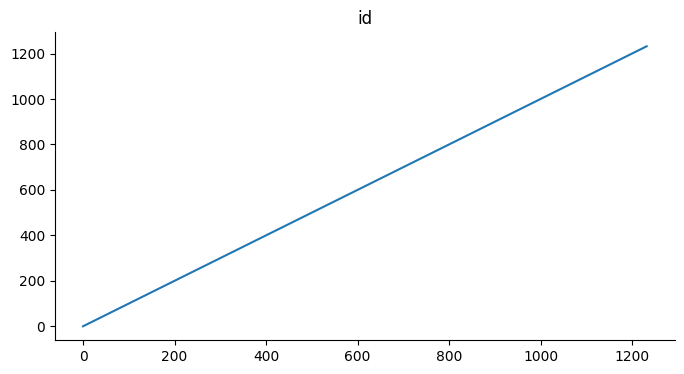

In [17]:


from matplotlib import pyplot as plt
data['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

In [18]:
data.reset_index(drop=True,inplace=True)

Here I create inverted index. Inverted index is a fundamental technology used commonly in search engine . Inverted index assigns each word with a list of document id and it helps retrieve the articles with keyword matching fastly. For example {'patient':[1,3,6]} means that the word patient occurs in the second,fourth and sixth document in the corpus.



In [19]:
inverted_idx = {}
for idx,sentence in enumerate(list(data['abstract_tokens'])):
    for token in set(sentence):
        if token not in inverted_idx:
            inverted_idx[token] = [idx]
        else:
            inverted_idx[token].append(idx)

print(f'There are {len(inverted_idx)} unique words in inverted index')

There are 8711 unique words in inverted index


# 2.Article Matching and Deep Cleaning

In [20]:
keywords_cov = ["sars-cov-2","sars","cov-2","2019-ncov","ncov","cov","covid19","covid","corona",
             "coronavirus"]
cov_idx = []
for word in keywords_cov:
    try:
        cov_idx += inverted_idx[word]
    except:
        pass
cov_idx = list(set(cov_idx))
print(f'Found {len(cov_idx)} articles related to covid19')

Found 606 articles related to covid19


In [21]:
cov_article = data.iloc[cov_idx,:]
cov_article.head()

,id,source,doi,pmcid,pubmed_id,publish_time,authors,journal,title,abstract,body,entities,abstract_tokens
1,2,CZI,10.3390/jcm9020538,,,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,Incubation Period and Other Epidemiological Ch...,the geographic spread of 2019 novel coronaviru...,"As of 31 January 2020, mainland China reported...","[{'text': '2019', 'start': 63, 'end': 67, 'typ...","[geographic, spread, novel, coronavirus, infec..."
2,3,CZI,10.3390/jcm9020575,,32093211,2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,Characteristics of and Public Health Responses...,"in december 2019, cases of unidentified pneumo...","In December 2019, a cluster of pneumonia of un...","[{'text': 'Public Health', 'start': 23, 'end':...","[december, cases, unidentified, pneumonia, his..."
3,5,CZI,10.1016/j.idm.2020.02.001,,,2020,"Tang, Biao; Bragazzi, Nicola Luigi; Li, Qian; ...",Infectious Disease Modelling,An updated estimation of the risk of transmiss...,the basic reproduction number of an infectious...,Coronaviruses are a group of enveloped viruses...,"[{'text': 'coronavirus', 'start': 63, 'end': 7...","[basic, reproduction, number, infectious, agen..."
4,6,CZI,10.1016/j.idm.2020.02.002,,,2020,"Roosa, K.; Lee, Y.; Luo, R.; Kirpich, A.; Roth...",Infectious Disease Modelling,Real-time forecasts of the 2019-nCoV epidemic ...,the initial cluster of severe pneumonia cases ...,The ongoing epidemic of the novel coronavirus ...,"[{'text': '2019-nCoV', 'start': 27, 'end': 36,...","[initial, cluster, severe, pneumonia, cases, t..."
6,9,CZI,10.1128/mBio.02764-19,,,2020,"Qing, Enya; Hantak, Michael; Perlman, Stanley;...",mBio,Distinct Roles for Sialoside and Protein Recep...,coronaviruses (covs) are common human and anim...,could be attributed to S proteins. Intriguingl...,"[{'text': 'Sialoside', 'start': 19, 'end': 28,...","[coronaviruses, covs, common, human, animal, p..."


For topic modeling and visualization, lemmatization is needed. POS tagging technique is also used to filter meaningful words.

In [22]:
def lemmatization(texts, allowed_postags=['NOUN','ADJ','VERB','ADV']):
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent))
        ##'-PRON-' is used as the lemma for all pronouns such as their, you, me, and I
        texts_out.append([token.lemma_ if token.lemma_ not in ['-PRON-'] else ''
                          for token in doc if token.pos_ in allowed_postags])
    return texts_out

First, let's see how the word cloud of this corpus looks like.

Text(0.5, 1.0, 'Word Cloud: Articles Related to SAR-Cov-2')

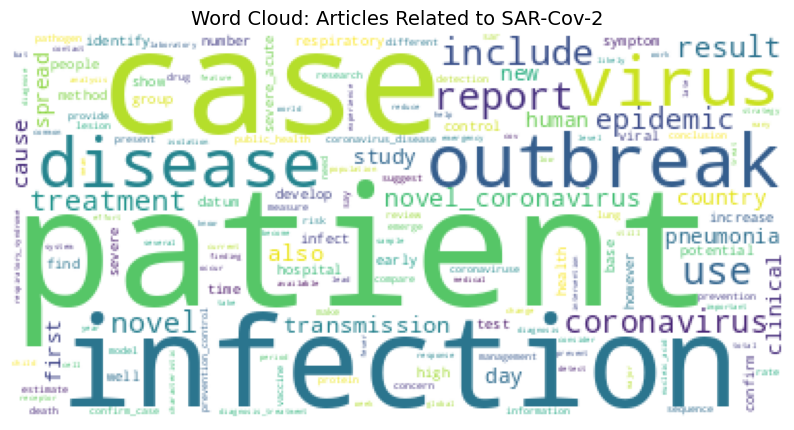

In [23]:
cov_article['Lemma_Tokens'] = lemmatization(list(cov_article['abstract_tokens']))
## convert tokens that frequently occur together as bigram and trigram
bigram = Phrases(list(cov_article['Lemma_Tokens']), min_count=3)
cov_article['Phrase_Lemma_Tokens'] = cov_article['Lemma_Tokens'].apply(lambda x: bigram[x])


cov_abstract_tokens = []
for tokens in list(cov_article['Phrase_Lemma_Tokens']):
    cov_abstract_tokens += tokens
cov_wordcnt_dict = collections.Counter(cov_abstract_tokens)

wcloud = wordcloud.WordCloud(background_color='white')
wcloud.generate_from_frequencies(cov_wordcnt_dict)
fig,ax = plt.subplots(figsize=(10,8))
ax.imshow(wcloud)
for pos in ['left','right','top','bottom']:
    ax.spines[pos].set_color(None)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Word Cloud: Articles Related to SAR-Cov-2' ,fontsize=14)

Words or phrases like  'patient', 'infection', 'disease', 'outbreak', 'virus', 'case, 'epidemic' occur frequently in this corpus.

# 3.Topic Extraction : LDA

100%|██████████| 8/8 [01:15<00:00,  9.42s/it]


Topic number selection took 75.38802886009216 seconds


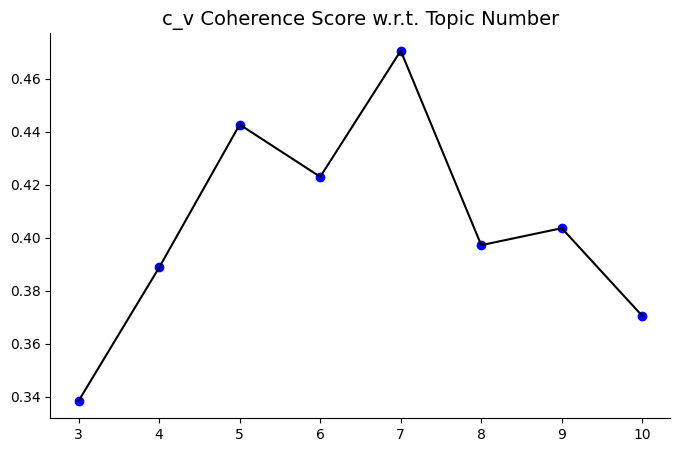

In [24]:

id2token_cov_article = corpora.Dictionary(list(cov_article['Phrase_Lemma_Tokens']))
corpus_cov_article = [id2token_cov_article.doc2bow(tokens)
                        for tokens in list(cov_article['Phrase_Lemma_Tokens'])]

begin_time = time.time()
coherence_scores = []
for nb_topics in tqdm(range(3,11)):
    lda_model = LdaMulticore(corpus=corpus_cov_article,
                            id2word=id2token_cov_article,
                            num_topics=nb_topics,
                            random_state=98,
                            chunksize=100,
                            passes=10,
                            iterations=50,
                            decay=0.5,
                            per_word_topics=True,)

    cm = CoherenceModel(model=lda_model,
                        texts=list(cov_article['Phrase_Lemma_Tokens']),
                        dictionary=id2token_cov_article,
                        coherence='c_v',
                        topn=20)
    coherence_score = cm.get_coherence()
    coherence_scores.append(coherence_score)

print(f'Topic number selection took {time.time()-begin_time} seconds')

fig,ax = plt.subplots(figsize=(8,5))
ax.plot(range(3,11),coherence_scores,color='black')
ax.scatter(range(3,11),coherence_scores,marker='o',color='blue')
ax.set_xticks(range(3,11,1))
ax.set_title('c_v Coherence Score w.r.t. Topic Number',fontsize=14)
#ax.set_xlabel('Number of Topics',fontsize=14)
for pos in ['top','right']:
    ax.spines[pos].set_color(None)

The higher the c_v coherence score is, the more suitable the topic number should be. Hence, I choose 8 as the topic number for analysis.

In [25]:
lda_model = LdaMulticore(corpus=corpus_cov_article,
                        id2word=id2token_cov_article,
                        num_topics=8,
                        random_state=98,
                        chunksize=100,
                        passes=10,
                        iterations=50,
                        decay=0.5,
                        per_word_topics=True,)

print('Perplexity: ', lda_model.log_perplexity(corpus_cov_article))

Perplexity:  -7.879639690669713


# Word per Topic

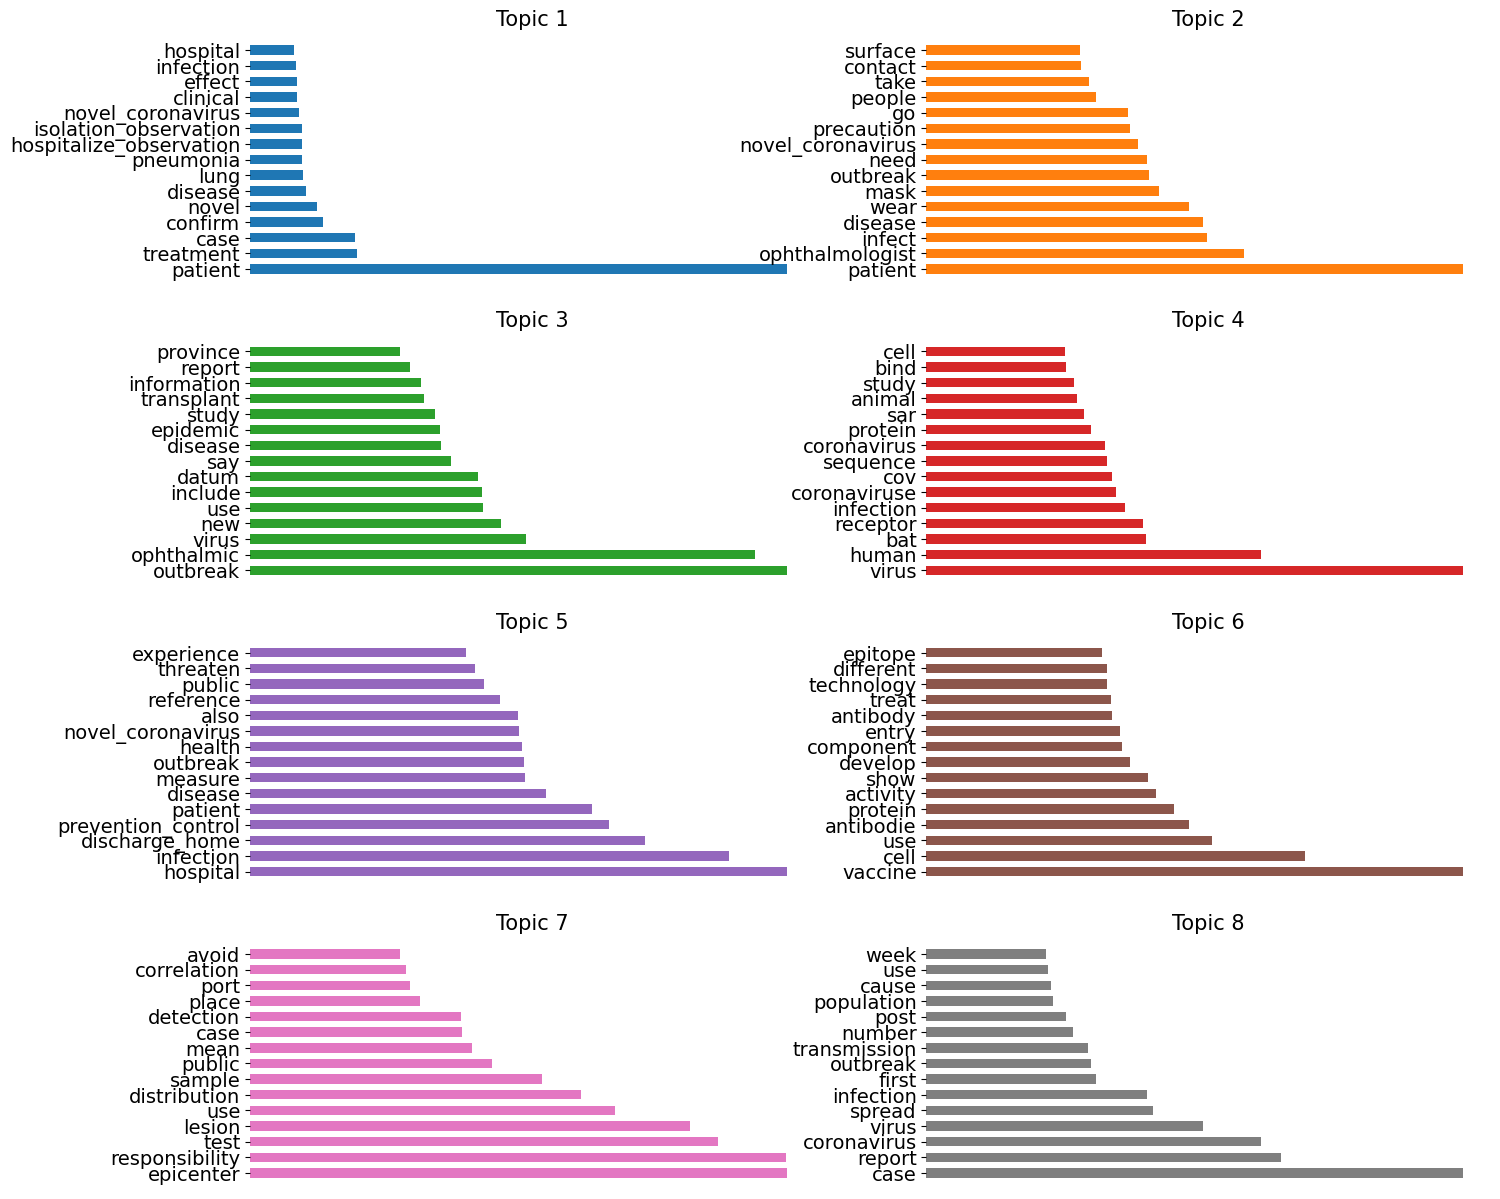

In [26]:
word_topic_scores = lda_model.show_topics(num_words=15,formatted=False)

fig = plt.figure(figsize=(16,15))
for i,topic in enumerate(word_topic_scores):
    word_score_pairs = topic[1]
    #word_score_dict = dict(topic[1])
    words = [word_score_pair[0] for word_score_pair in word_score_pairs]
    probs = [word_score_pair[1] for word_score_pair in word_score_pairs]
    #fig,ax = plt.subplots(figsize=(7,5))
    ax = fig.add_subplot(4,2,i+1)
    ax.barh(y=words,width=probs,height=0.6,color=sns.color_palette()[i])
    ax.set_yticklabels(labels=words, fontsize=14)
    ax.set_xticks([])
    ax.set_title(f'Topic {i+1}',fontsize=15)
    for pos in ['left','right','bottom','top']:
        ax.spines[pos].set_color(None)

•	The first topic highlights the role of hospitals in ensuring public health through the adoption of treatment strategies and infection prevention control measures.
We can see words like 'infection', 'hospital', 'novel', 'prevention_control','public health','treatment '.

•	The second topic delves into the evolution of the virus within the human host, touching upon aspects like viral infection at the cellular level. We can see words like, 
'human', 'cell','host','protein','infection' .

•	The third topic discusses the efforts of scientists in testing western drugs in labs, specifically for conditions like atypical pneumonia and myocardial issues. We can see words like, 'lab', 'test', 'ventilator', 'drug','western','atypical pneumonia'.

•	The fourth topic suggests that a significant number of patient cases originated from the distribution of lesions in infected lungs. We can see words like lesion', 'infection', 'lung'.

•	The fifth topic talks about the observation of hospitalized COVID-19 confirmed patients, focusing on syndrome identification, treatment effects, and precautions taken during isolation. We can see words like 'syndrome', 'confirm', 'hospitalize_observation'.

•	The sixth topic addresses the rise in COVID-19 cases in the country, hinting at aspects like transmission, outbreak reporting, and the virus itself. We can see words like 'case', 'transmission', 'outbreak'.

•	The seventh topic likely discusses the symptoms of COVID-19 in a patient, with a particular emphasis on fever. We can see words like,'case','fever','high'.

•	The eighth topic seems to discuss the psychological impact of the pandemic, research on vaccines by scientists in the medical world, and COVID-19 cases in wild animals. We can see words like'vaccine','scientist', ‘medical','journal'.


# 4. LDA Visualization

In [29]:
!pip install pandas


In [27]:
from pyLDAvis import gensim

In [30]:
!pip install --upgrade ipython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.0/812.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 10.2 MB/s eta 0:00:00
  Attempting uninstall: traitlets
    Found existing installation: traitlets 5.7.1
    Uninstalling traitlets-5.7.1:
      Successfully uninstalled traitlets-5.7.1
  Attempting uninstall: ipython
    Found existing installation: ipython 7.34.0
    Uninstalling ipython-7.34.0:
      Successfully uninstalled ipython-7.34.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython==7.34.0, but you have ipython 8.22.2 which is incompatible.


In [32]:
pip install ipython==7.34.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.8/793.8 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: ipython
    Found existing installation: ipython 8.22.2
    Uninstalling ipython-8.22.2:
      Successfully uninstalled ipython-8.22.2


In [39]:

import time
import pyLDAvis
import pyLDAvis.gensim

# Start measuring time
start_time = time.time()

pyLDAvis.enable_notebook()

# Replace lda_model, corpus_cov_article, and id2token_cov_article with your actual objects/data
# Prepare and display the visualization
vis = pyLDAvis.gensim.prepare(lda_model, corpus_cov_article, id2token_cov_article)

# Print the execution time
print("Execution time:", time.time() - start_time, "seconds")

Execution time: 14.144890546798706 seconds


In [71]:
%%time
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus_cov_article, id2token_cov_article)

CPU times: user 570 ms, sys: 728 ms, total: 1.3 s
Wall time: 8.23 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.155192  0.152433       1        1  23.137229
7      0.035949 -0.172561       2        1  22.887166
4     -0.095469  0.031237       3        1  16.634035
2      0.050507 -0.115915       4        1  13.615354
3      0.143280 -0.076593       5        1  10.455375
1     -0.277299 -0.055822       6        1   4.904399
5      0.173332  0.094229       7        1   4.232097
6      0.124891  0.142994       8        1   4.134345, topic_info=             Term         Freq        Total Category  logprob  loglift
241       patient  1141.000000  1141.000000  Default  30.0000  30.0000
53          virus   368.000000   368.000000  Default  29.0000  29.0000
57           case   563.000000   563.000000  Default  28.0000  28.0000
3739   ophthalmic   114.000000   114.000000  Default  27.0000  27.0000
904      hospital   235.000000   235.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
57           case    10.984251   563.928784   Topic8  -5.2116  -0.7526
1496  improvement     6.435701    34.495531   Topic8  -5.7462   1.5069
301         first     7.173356   159.175074   Topic8  -5.6377   0.0862
307      increase     6.079532    86.179309   Topic8  -5.8031   0.5343
993    laboratory     5.674162    38.111969   Topic8  -5.8721   1.2812

[511 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3790      6  0.905047  accumulate
778       2  0.290845    activity
778       3  0.174507    activity
778       7  0.523520    activity
1267      6  0.842045         add
...     ...       ...         ...
197       7  0.046286        well
417       2  0.520220       world
417       4  0.438935       world
417       8  0.032514       world
270       2  0.955181         yet

[922 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 5, 3, 4, 2, 6, 7])

As we can see from the interactive figure of Intertopic Distance Map (via multidimensional scaling) & Top-30 Most Relevant Terms for Topic 1 


# Topic per document

In [33]:
document_topic_distribution = []
num_topic_document = []
topic_frequency = {}
for i in range(len(corpus_cov_article)):
    document_topic = lda_model.get_document_topics(corpus_cov_article[i])
    document_topic_distribution.append(document_topic)
    num_topic_document.append(len(document_topic))
    for topic_idx,prob in document_topic:
        if topic_idx not in topic_frequency:
            topic_frequency[topic_idx] = 1
        else:
            topic_frequency[topic_idx] += 1

topic_frequency = dict(sorted(topic_frequency.items()))

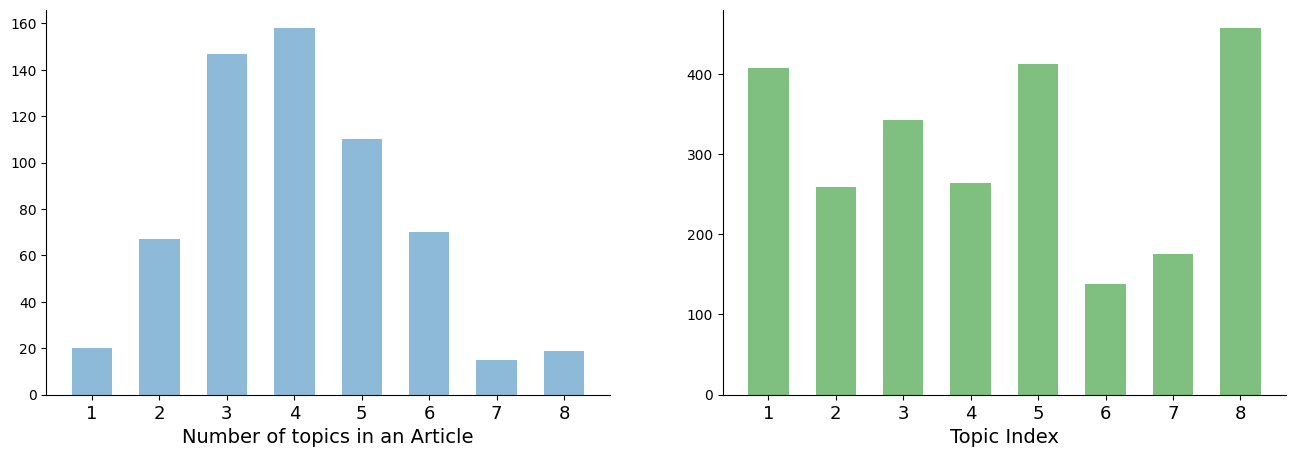

In [50]:
#num_topic_document_counter = collections.Counter(num_topic_document)
num_topic_document_counter = (pd.DataFrame(num_topic_document)).value_counts(sort=False)
counter_idx = [str(idx[0]) for idx in num_topic_document_counter.index]
counter_values = num_topic_document_counter.values
fig,axes = plt.subplots(figsize=(16,5),nrows=1,ncols=2)
axes[0].bar(counter_idx, counter_values,width=0.6,alpha=0.5)
axes[0].set_xlabel('Number of topics in an Article',fontsize=14)

df_topic_frequency = pd.DataFrame.from_dict(topic_frequency,orient='index')
topic_idxs = [str(idx+1) for idx in df_topic_frequency.index]
axes[1].bar(topic_idxs, df_topic_frequency.iloc[:,0], width=0.6,color='green',alpha=0.5)
axes[1].set_xlabel('Topic Index',fontsize=14)

for ax in axes:
    for pos in ['top','right']:
        ax.spines[pos].set_color(None)
    ax.set_xticklabels(['1','2','3','4','5','6','7','8'],fontsize=13)

1.The left figure shows that there are very few articles who covered all the topics. 3rd and 4th topic are mostly present in many articles..

2.The right figure shows that occurence frequencies of topics are not very close as we can see many articles covered 1st and 6th topic.


In [35]:
## Generate document topic matrix
document_topic_matrix = np.zeros((len(corpus_cov_article),8))
for idx,document_topic in enumerate(document_topic_distribution):
    for topic_idx,prob in document_topic:
        document_topic_matrix[idx][topic_idx] = prob
pd.DataFrame(document_topic_matrix).head()

,0,1,2,3,4,5,6,7
0,0.165937,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.823475
1,0.196839,0.000000,0.000000,0.000000,0.333749,0.00000,0.00000,0.461869
2,0.020182,0.074183,0.108584,0.000000,0.000000,0.04448,0.00000,0.749412
3,0.071076,0.214592,0.290189,0.000000,0.000000,0.00000,0.01972,0.401868
4,0.000000,0.000000,0.000000,0.571408,0.423650,0.00000,0.00000,0.000000


In [49]:
#T-SNE clustering of LDA topics
tSNE = TSNE(n_components=2,init='pca',random_state=98)
embedding_matrix = tSNE.fit_transform(document_topic_matrix)
df_embedding = pd.DataFrame(embedding_matrix, columns=['X_TSNE','Y_TSNE'])
cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow',
                  3: 'red', 4: 'skyblue', 5:'salmon',
                  6: 'purple', 7:'darkred'}
df_embedding['dominant_topic_idx'] = np.argmax(document_topic_matrix,axis=1)
df_embedding['color'] = df_embedding['dominant_topic_idx'].map(cluster_colors)
cluster_labels = {0: 'Infection prevention measures by hospital', 1: 'Evolution of virus',
                  2: 'Drugs for atypical pneumonia and myocardial',
                  3: 'lesions in lungs', 4: 'Observation on COVID19 patient', 5:'Rise of COVID19 in the Country',
                  6: 'Symptoms of COVID19', 7: 'Research on vaccine'}
df_embedding['label'] = df_embedding['dominant_topic_idx'].map(cluster_labels)
df_embedding['article_title'] = list(cov_article['title'])

output_notebook()

source = ColumnDataSource(
    dict(x = df_embedding['X_TSNE'],
         y = df_embedding['Y_TSNE'],
         color=df_embedding['color'],
         label=df_embedding['label'],
         topic_key= df_embedding['dominant_topic_idx'],
         title= df_embedding['article_title'],
         #content =
        ))

lda_plot = figure(title='T-SNE Clustering of LDA Topics',
              width=800, height=600,
              tools='pan,wheel_zoom,box_zoom,reset,hover',
              x_axis_type=None, y_axis_type=None)
lda_plot.scatter(x='x', y='y', source=source, color='color',alpha=0.7, size=10)
hover = lda_plot.select(dict(type=HoverTool))
hover.tooltips = {'content':'Title: @title'}
lda_plot.legend.location = 'bottom_right'
show(lda_plot)

# **Semantic-Based Search**

In [40]:
# Imports
!pip install langdetect


import string
import warnings

from pprint import pprint
from IPython.utils import io
from gensim.models import Word2Vec
from langdetect import DetectorFactory, detect
from spacy.lang.en.stop_words import STOP_WORDS

warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=978ce729ef97d4932ca41a442eb68c33482427738ba4308fdb28070dac39ae8b
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [41]:
#clearing cache to avoid ran out of memory error
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

In [42]:
#creating new dataframe for required columns
df_covid = pd.DataFrame(columns=['paper_id', 'title','abstract', 'doi'])
df_covid['paper_id'] = data.id
df_covid['title'] = data.title
df_covid['abstract'] = data.abstract
df_covid['doi'] = data.doi

df_covid.head()

,paper_id,title,abstract,doi
0,0,Angiotensin-converting enzyme 2 (ACE2) as a SA...,,10.1007/s00134-020-05985-9
1,2,Incubation Period and Other Epidemiological Ch...,the geographic spread of 2019 novel coronaviru...,10.3390/jcm9020538
2,3,Characteristics of and Public Health Responses...,"in december 2019, cases of unidentified pneumo...",10.3390/jcm9020575
3,5,An updated estimation of the risk of transmiss...,the basic reproduction number of an infectious...,10.1016/j.idm.2020.02.001
4,6,Real-time forecasts of the 2019-nCoV epidemic ...,the initial cluster of severe pneumonia cases ...,10.1016/j.idm.2020.02.002


# Duplicates and Null values.

We will look into the data and check if we have any null values.

In [43]:
#dropping articles with missing abstract
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 773 entries, 0 to 772
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   paper_id  773 non-null    int64 
 1   title     773 non-null    object
 2   abstract  773 non-null    object
 3   doi       773 non-null    object
dtypes: int64(1), object(3)
memory usage: 24.3+ KB


In [44]:
df_covid.drop_duplicates(['abstract'], inplace=True)
df_covid.dropna(inplace=True)
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 773 entries, 0 to 772
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   paper_id  773 non-null    int64 
 1   title     773 non-null    object
 2   abstract  773 non-null    object
 3   doi       773 non-null    object
dtypes: int64(1), object(3)
memory usage: 30.2+ KB


# Dropping non-English articles.

Now we dropped the null values, and removed the duplicates as well. Now we will check the number of non-english articles and see if we can drop them for the sake of simplicity.

In [45]:
# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df_covid))):
    # split by space into list, take the first x intex, join with space
    text = df_covid.iloc[ii]['abstract'].split(" ")

    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))

        except Exception as e:
            lang = "unknown"
            pass

    # get the language
    languages.append(lang)

100%|██████████| 773/773 [00:06<00:00, 115.31it/s]


**Let's look at the numbers of articles for each language.**

In [46]:
#clearing cache to avoid ran out of memory error
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

In [47]:
languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)

print("Total: {}\n".format(len(languages)))
print(languages_dict)

Total: 773

{'es': 11, 'ja': 1, 'unknown': 1, 'zh-cn': 4, 'en': 749, 'ca': 1, 'de': 2, 'pt': 4}


**Since most of the articles are in English, we can safely drop non-English articles.**

In [48]:
df_covid['language'] = languages
df_covid = df_covid[df_covid['language'] == 'en']
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 749 entries, 1 to 772
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   paper_id  749 non-null    int64 
 1   title     749 non-null    object
 2   abstract  749 non-null    object
 3   doi       749 non-null    object
 4   language  749 non-null    object
dtypes: int64(1), object(4)
memory usage: 35.1+ KB


In [51]:
df_covid = df_covid.drop(['language'], axis = 1)
df_covid.head()

,paper_id,title,abstract,doi
1,2,Incubation Period and Other Epidemiological Ch...,the geographic spread of 2019 novel coronaviru...,10.3390/jcm9020538
2,3,Characteristics of and Public Health Responses...,"in december 2019, cases of unidentified pneumo...",10.3390/jcm9020575
3,5,An updated estimation of the risk of transmiss...,the basic reproduction number of an infectious...,10.1016/j.idm.2020.02.001
4,6,Real-time forecasts of the 2019-nCoV epidemic ...,the initial cluster of severe pneumonia cases ...,10.1016/j.idm.2020.02.002
5,8,COVID-19 outbreak on the Diamond Princess crui...,cruise ships carry a large number of people in...,10.1093/jtm/taaa030


In [52]:
#clearing cache to avoid ran out of memory error
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

# Spacy Parser and Tokenizer

In [53]:
punctuations = string.punctuation

stopwords = list(STOP_WORDS)
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure',
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.',
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [58]:
! python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/spacy/__main__.py", line 4, in <module>
    setup_cli()
  File "/usr/local/lib/python3.10/dist-packages/spacy/cli/_util.py", line 87, in setup_cli
    command(prog_name=COMMAND)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1157, in __call__
    return self.main(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/typer/core.py", line 778, in main
    return _main(
  File "/usr/local/lib/python3.10/dist-packages/typer/core.py", line 216, in _main
    rv = self.invoke(ctx)
  File "/usr/l

In [59]:
# Parser
parser = spacy.load('en_core_web_lg',disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens


tqdm.pandas()
df_covid["processed_abstract"] = df_covid["abstract"].progress_apply(spacy_tokenizer)
df_covid.head()

100%|██████████| 749/749 [00:53<00:00, 14.11it/s]


,paper_id,title,abstract,doi,centroid,processed_abstract
1,2,Incubation Period and Other Epidemiological Ch...,the geographic spread of 2019 novel coronaviru...,10.3390/jcm9020538,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",geographic spread 2019 novel coronavirus covid...
2,3,Characteristics of and Public Health Responses...,"in december 2019, cases of unidentified pneumo...",10.3390/jcm9020575,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",december 2019 cases unidentified pneumonia his...
3,5,An updated estimation of the risk of transmiss...,the basic reproduction number of an infectious...,10.1016/j.idm.2020.02.001,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",basic reproduction number infectious agent ave...
4,6,Real-time forecasts of the 2019-nCoV epidemic ...,the initial cluster of severe pneumonia cases ...,10.1016/j.idm.2020.02.002,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",initial cluster severe pneumonia cases trigger...
5,8,COVID-19 outbreak on the Diamond Princess crui...,cruise ships carry a large number of people in...,10.1093/jtm/taaa030,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",cruise ships carry large number people confine...


In [60]:
#clearing cache to avoid ran out of memory error
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

# Sentence Tokenization
gensim's word2vec corpus should be in the form of separate sentences, therefore we will use spacy's tokenizer in order to split the corpus (all the abstracts) into sentences.

In [61]:
#sentence tokenization to prepare the corpus
abstracts = df_covid['abstract'].values

nlp = spacy.load('en_core_web_lg',disable = ['ner', 'tagger'])
nlp.add_pipe('sentencizer', before="parser")
word2vec_corpus = []

for i in tqdm(range(0, len(abstracts))):
    raw_text = abstracts[i]
    doc = nlp(raw_text)
    sentences = [sent.text.strip() for sent in doc.sents]

    for sent in sentences:
        processed_sent = spacy_tokenizer(sent)
        processed_sent_list = processed_sent.split(" ")
        word2vec_corpus.append(processed_sent_list)

100%|██████████| 749/749 [01:12<00:00, 10.29it/s]


In [62]:
word2vec_corpus[:10]

[['geographic',
  'spread',
  '2019',
  'novel',
  'coronavirus',
  'covid-19',
  'infections',
  'epicenter',
  'wuhan',
  'china',
  'provided',
  'opportunity',
  'study',
  'natural',
  'history',
  'recently',
  'emerged',
  'virus'],
 ['publicly',
  'available',
  'event',
  'date',
  'data',
  'ongoing',
  'epidemic',
  'present',
  'study',
  'investigated',
  'incubation',
  'period',
  'time',
  'intervals',
  'govern',
  'epidemiological',
  'dynamics',
  'covid-19',
  'infections'],
 ['results',
  'incubation',
  'period',
  'falls',
  'range',
  '2&ndash;14',
  'days',
  '95',
  'confidence',
  'mean',
  '5',
  'days',
  'approximated',
  'best',
  'fit',
  'lognormal',
  'distribution'],
 ['mean',
  'time',
  'illness',
  'onset',
  'hospital',
  'admission',
  'treatment',
  'and/or',
  'isolation',
  'estimated',
  '3&ndash;4',
  'days',
  'truncation',
  '5&ndash;9',
  'days',
  'right',
  'truncated'],
 ['based',
  '95th',
  'percentile',
  'estimate',
  'incubation',

# Word2vec Training


In [63]:
# Train the genisim word2vec model with our own custom corpus
model = Word2Vec(word2vec_corpus, min_count=3,vector_size= 50,workers=4, window =5, sg = 1)

In [64]:
#calculate the centroid for each abstract

a = [0.0]*50
df_covid["centroid"] = [a]*df_covid.shape[0]

for index, row in df_covid.iterrows():
    abstract = row['processed_abstract']
    total_sim = 0
    words = abstract.split(" ")
    centroid = np.array([0.0]*50)
    for word in words:
        try:
            b = model[word]
        except:
            continue
        centroid = np.add(centroid, b)

    df_covid.at[index,'centroid'] = centroid.tolist()

df_covid.head()

,paper_id,title,abstract,doi,centroid,processed_abstract
1,2,Incubation Period and Other Epidemiological Ch...,the geographic spread of 2019 novel coronaviru...,10.3390/jcm9020538,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",geographic spread 2019 novel coronavirus covid...
2,3,Characteristics of and Public Health Responses...,"in december 2019, cases of unidentified pneumo...",10.3390/jcm9020575,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",december 2019 cases unidentified pneumonia his...
3,5,An updated estimation of the risk of transmiss...,the basic reproduction number of an infectious...,10.1016/j.idm.2020.02.001,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",basic reproduction number infectious agent ave...
4,6,Real-time forecasts of the 2019-nCoV epidemic ...,the initial cluster of severe pneumonia cases ...,10.1016/j.idm.2020.02.002,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",initial cluster severe pneumonia cases trigger...
5,8,COVID-19 outbreak on the Diamond Princess crui...,cruise ships carry a large number of people in...,10.1093/jtm/taaa030,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",cruise ships carry large number people confine...


In [65]:
def rank_docs(model, query, df_covid, num) :
    #[(paper_id, processed_abstract, url, cosine_sim)]
    cosine_list = []

    a = []
    query = query.split(" ")
    for q in query:
        try:
            a.append(model[q])
        except:
            continue

    for index, row in df_covid.iterrows():
        centroid = row['centroid']
        total_sim = 0
        for a_i in a:
            cos_sim = np.dot(a_i, centroid)/(np.linalg.norm(a_i)*np.linalg.norm(centroid))
            total_sim += cos_sim
        cosine_list.append((row['title'], row['doi'], total_sim))


    cosine_list.sort(key=lambda x:x[2], reverse=True) ## in Descedning order

    papers_list = []
    for item in cosine_list[:num]:
        papers_list.append((item[0], item[1], item[2]))
    return papers_list

#  The model and the dataframe

In [66]:
model.save("./model.model")
df_covid.to_pickle("./df_covid.pkl")

**Loading the model and the data**

The save/load steps are done in order to avoid re-training the model each time.

In [67]:
saved_model = Word2Vec.load("./model.model")
saved_df_covid = pd.read_pickle("./df_covid.pkl")

# Results
Now let's see some results using our model. query() function takes the query string as an input, together with a number representing the top matches you want, and print the titles of the top matches most relevant articles retrieved for each query.

In [76]:
def query(the_query, top_matches=10):
    q = spacy_tokenizer(the_query)
    try:
        model_to_use = model
    except:
        model_to_use = saved_model
    try:
        df_covid_to_use = df_covid
    except:
        df_covid_to_use = saved_df_covid
    results = rank_docs(model_to_use, q, df_covid_to_use, top_matches)

    for i in range(len(results)):
        paper_name = results[i][0]
        paper_doi = results[i][1]
        paper_link = "https://doi.org/" + str(paper_doi)
        display(paper_name)
        display(paper_link)


In [77]:
query('origin of coronavirus')

'Incubation Period and Other Epidemiological Characteristics of 2019 Novel Coronavirus Infections with Right Truncation: A Statistical Analysis of Publicly Available Case Data'

'https://doi.org/10.3390/jcm9020538'

'Characteristics of and Public Health Responses to the Coronavirus Disease 2019 Outbreak in China'

'https://doi.org/10.3390/jcm9020575'

'An updated estimation of the risk of transmission of the novel coronavirus (2019-nCov)'

'https://doi.org/10.1016/j.idm.2020.02.001'

'Real-time forecasts of the 2019-nCoV epidemic in China from February 5th to February 24th, 2020'

'https://doi.org/10.1016/j.idm.2020.02.002'

'COVID-19 outbreak on the Diamond Princess cruise ship: estimating the epidemic potential and effectiveness of public health countermeasures'

'https://doi.org/10.1093/jtm/taaa030'

'Distinct Roles for Sialoside and Protein Receptors in Coronavirus Infection'

'https://doi.org/10.1128/mBio.02764-19'

'First two\xa0months of the 2019 Coronavirus Disease (COVID-19) epidemic in China: real-time surveillance and evaluation with a second derivative model'

'https://doi.org/10.1186/s41256-020-00137-4'

'Effectiveness of airport screening at detecting travellers infected with novel coronavirus (2019-nCoV)'

'https://doi.org/10.2807/1560-7917.ES.2020.25.5.2000080'

'Genome Detective Coronavirus Typing Tool for rapid identification and characterization of novel coronavirus genomes'

'https://doi.org/10.1093/bioinformatics/btaa145'

'Case of the Index Patient Who Caused Tertiary Transmission of Coronavirus Disease 2019 in Korea: the Application of Lopinavir/Ritonavir for the Treatment of COVID-19 Pneumonia Monitored by Quantitative RT-PCR'

'https://doi.org/10.3346/jkms.2020.35.e79'

In [78]:
query('Where do 2022-ncov originated')

'Incubation Period and Other Epidemiological Characteristics of 2019 Novel Coronavirus Infections with Right Truncation: A Statistical Analysis of Publicly Available Case Data'

'https://doi.org/10.3390/jcm9020538'

'Characteristics of and Public Health Responses to the Coronavirus Disease 2019 Outbreak in China'

'https://doi.org/10.3390/jcm9020575'

'An updated estimation of the risk of transmission of the novel coronavirus (2019-nCov)'

'https://doi.org/10.1016/j.idm.2020.02.001'

'Real-time forecasts of the 2019-nCoV epidemic in China from February 5th to February 24th, 2020'

'https://doi.org/10.1016/j.idm.2020.02.002'

'COVID-19 outbreak on the Diamond Princess cruise ship: estimating the epidemic potential and effectiveness of public health countermeasures'

'https://doi.org/10.1093/jtm/taaa030'

'Distinct Roles for Sialoside and Protein Receptors in Coronavirus Infection'

'https://doi.org/10.1128/mBio.02764-19'

'First two\xa0months of the 2019 Coronavirus Disease (COVID-19) epidemic in China: real-time surveillance and evaluation with a second derivative model'

'https://doi.org/10.1186/s41256-020-00137-4'

'Effectiveness of airport screening at detecting travellers infected with novel coronavirus (2019-nCoV)'

'https://doi.org/10.2807/1560-7917.ES.2020.25.5.2000080'

'Genome Detective Coronavirus Typing Tool for rapid identification and characterization of novel coronavirus genomes'

'https://doi.org/10.1093/bioinformatics/btaa145'

'Case of the Index Patient Who Caused Tertiary Transmission of Coronavirus Disease 2019 in Korea: the Application of Lopinavir/Ritonavir for the Treatment of COVID-19 Pneumonia Monitored by Quantitative RT-PCR'

'https://doi.org/10.3346/jkms.2020.35.e79'